In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
#import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys, os
from design_space import sample_design_space
from scipy.stats import norm
from scipy import stats
#from lmfit.models import SkewedGaussianModel
%matplotlib inline

## Load Data

In [40]:
data = pd.read_excel('../Size Exploration/SAXS/Volumes_and_Structure.xlsx')
data.fillna(0, inplace=True)

In [41]:
data

,Index,WP position,2mM_PVP-stock,Water-stock,2mM_TA-stock,2mM_AA-stock,2mM_SN-stock,0.025mM_Seeds-stock,P_length,P_radius,P_radius_pd,P_scale,S_radius,S_scale,Peak_WV
0,0,A1,35,204,5,3,43,35,65.690546,154.438502,0.318060,0.000210,0.000000,0.000000,495
1,1,A2,18,212,13,3,28,51,63.067699,158.073983,0.347873,0.000112,0.000000,0.000000,495
2,2,A3,49,130,46,2,49,49,47.260989,219.410736,0.260328,0.000202,136.000320,0.000040,550
3,3,A4,45,189,10,4,20,57,42.474913,98.150601,0.713521,0.000133,0.000000,0.000000,465
4,4,A5,44,162,38,5,25,51,42.008004,157.231997,0.327596,0.000202,0.000000,0.000000,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,D1,24,224,22,8,14,33,38.720361,92.227600,0.702182,0.000137,0.000000,0.000000,490
133,133,D2,31,198,17,3,38,38,58.099514,173.932918,0.243172,0.000246,0.000000,0.000000,525
134,134,D3,26,192,9,9,51,38,66.109781,131.086537,0.481546,0.000211,0.000000,0.000000,500
135,135,D4,11,195,30,27,13,49,32.787068,72.132653,0.758254,0.000151,69.936313,0.000023,465


In [47]:
data = pd.read_excel('../Size Exploration/SAXS/Volumes_and_Structure.xlsx')
data.fillna(0, inplace=True)
data = data.values
PVP = (data[:,2]*2/325).reshape(-1,1)
TA = (data[:,4]*2/325).reshape(-1,1)
AA = (data[:,5]*2/325).reshape(-1,1)
SN = (data[:,6]*2/325).reshape(-1,1)
Seeds = (data[:,7]*0.025/325).reshape(-1,1) #Use mM as units 
x = np.hstack((PVP, TA, AA, SN, Seeds))
X = x.copy() 
thickness = (data[:,8]).reshape(-1,1)
radius = (data[:,9]).reshape(-1,1)
P_radius_PD = (data[:,10]).reshape(-1,1)
p_scale = (data[:,12]).reshape(-1,1)
s_radius = (data[:,12]).reshape(-1,1)
peak_wv = (data[:,13]).reshape(-1,1)

In [48]:
thickness = (data[:,8]).reshape(-1,1)
radius = (data[:,9]).reshape(-1,1)
scale = (data[:,10]).reshape(-1,1)
s_radius = (data[:,11]).reshape(-1,1)
y = np.hstack((thickness, radius, P_radius_PD))
Y = y.copy()
t = radius

In [49]:
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)
scaler = MinMaxScaler()
t = scaler.fit(t).transform(t)

X_train, X_test, y_train, y_test = train_test_split(X, t,
                                            test_size=0.10,
                                            random_state=703)

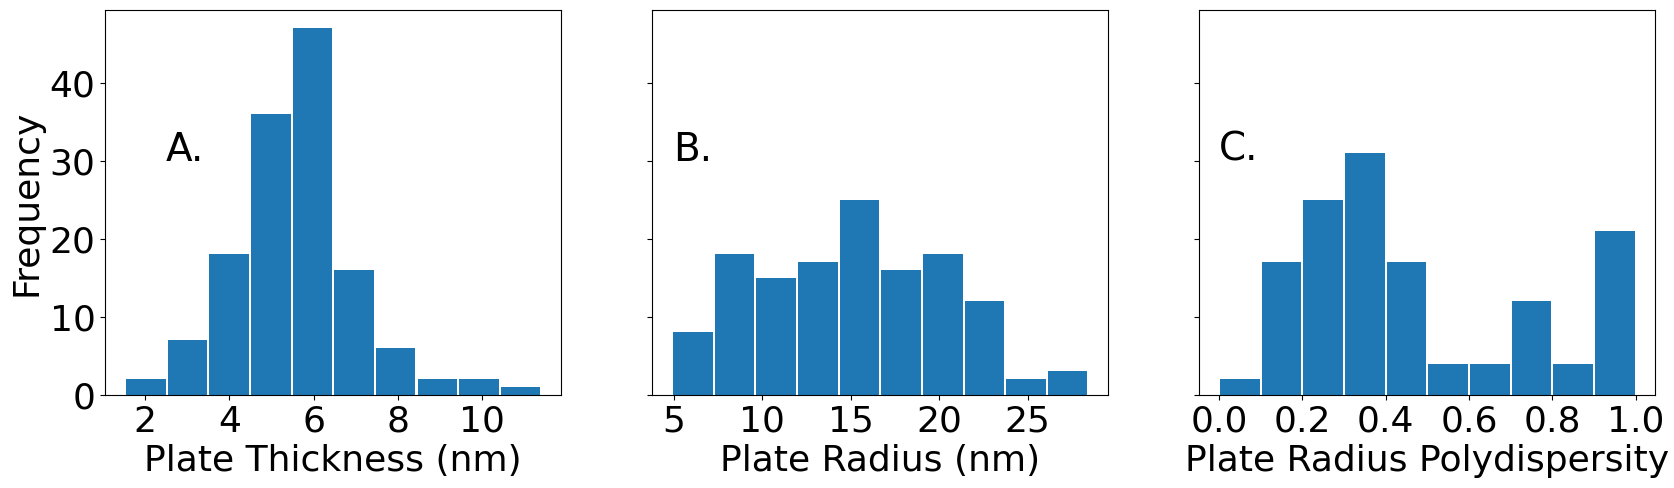

In [50]:
plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(ncols=3, figsize=(20,5), sharey=True)

data = (y[:,0].reshape(-1,1)/10).astype('float')
ax[0].hist(data, bins=10, rwidth=0.95)
X = np.linspace(min(data), max(data))
#ax[0].plot(X, stats.skewnorm.pdf(X, *stats.skewnorm.fit(data))*120, color = 'red', linewidth=5)
ax[0].set_xlabel('Plate Thickness (nm)')
ax[0].set_ylabel('Frequency')
ax[0].text(2.5, 30, 'A.', fontsize=28)
ax[0].set_xticks([2, 4, 6, 8, 10])
#ax3=ax[0].twinx()
#ax3.plot(X, stats.skewnorm.cdf(X, *stats.skewnorm.fit(data)), color = 'black', linewidth=5, label = 'Gaussian CDF')
#ax3.axis('off')

data = (y[:,1].reshape(-1,1)/10).astype('float')
data = data[data < 30]
ax[1].hist(data, bins=10, rwidth=0.95)
ax[1].set_xlabel('Plate Radius (nm)')
ax[1].text(5, 30, 'B.', fontsize=28)
X = np.linspace(min(data), max(data))
#ax[1].plot(X, stats.skewnorm.pdf(X, *stats.skewnorm.fit(data))*200, color = 'red', linewidth=5, label = 'Normal PDF')
#plt.legend(loc='upper right')
ax[1].set_xticks([5, 10, 15, 20, 25])
#ax3=ax[1].twinx()
#ax3.plot(X, stats.skewnorm.cdf(X, *stats.skewnorm.fit(data)), color = 'black', linewidth=5, label = 'Model CDF')
#ax3.axis('off')

data = (y[:,2].reshape(-1,1)).astype('float')
data = data[data < 30]
ax[2].hist(data, bins=10, rwidth=0.95)
ax[2].set_xlabel('Plate Radius Polydispersity')
ax[2].text(0, 30, 'C.', fontsize=28)
ax[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
X = np.linspace(min(data), max(data))


#plt.savefig('../../Figures/230421/Histogram_Size.jpg', dpi = 400, bbox_inches="tight")
plt.show()

## Fit Model

In [36]:
def plot_data_2D(X, t):
    scaler = MinMaxScaler()
    t = scaler.fit(t).transform(t)
    plt.scatter(X[:,0], X[:,1], marker='o', edgecolors='Red', facecolors='none', s=t*400, linewidth = 3, alpha = 1, label = 'Plate Thickness')

def plot_data_2D_2(X, t):
    scaler = MinMaxScaler()
    t = scaler.fit(t).transform(t)
    good_fit_loc = np.where(t ==0)[0]
    X = X[good_fit_loc,:]
    plt.scatter(X[:,0], X[:,1], marker='P', edgecolors='Black', facecolors='none', s=350, linewidth = 3, alpha = 1, label = 'Mean-Squared Error')
    
def plot_pt_2D(grid_x, grid_y, grid_z, label):
    plt.contourf(grid_x, grid_y, grid_z, cmap='Purples', alpha=1, levels=np.linspace(0, 1, 11))
    cbar = plt.colorbar(format='%.2f')
    cbar.set_label(label, rotation=270, labelpad=30)

def plot_db_2D(grid_x, grid_y, grid_z, decision_boundary=0.5):
    levels = [decision_boundary]
    cs = plt.contour(grid_x, grid_y, grid_z, levels=levels, colors='orange', linestyles='dashed', linewidths=10)
    plt.clabel(cs, fontsize=20)

## Fit Model with 2 Features

In [52]:
data = pd.read_excel('../Size Exploration/SAXS/Volumes_and_Structure.xlsx')
data.fillna(0, inplace=True)
data

,Index,WP position,2mM_PVP-stock,Water-stock,2mM_TA-stock,2mM_AA-stock,2mM_SN-stock,0.025mM_Seeds-stock,P_length,P_radius,P_radius_pd,P_scale,S_radius,S_scale,Peak_WV
0,0,A1,35,204,5,3,43,35,65.690546,154.438502,0.318060,0.000210,0.000000,0.000000,495
1,1,A2,18,212,13,3,28,51,63.067699,158.073983,0.347873,0.000112,0.000000,0.000000,495
2,2,A3,49,130,46,2,49,49,47.260989,219.410736,0.260328,0.000202,136.000320,0.000040,550
3,3,A4,45,189,10,4,20,57,42.474913,98.150601,0.713521,0.000133,0.000000,0.000000,465
4,4,A5,44,162,38,5,25,51,42.008004,157.231997,0.327596,0.000202,0.000000,0.000000,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,D1,24,224,22,8,14,33,38.720361,92.227600,0.702182,0.000137,0.000000,0.000000,490
133,133,D2,31,198,17,3,38,38,58.099514,173.932918,0.243172,0.000246,0.000000,0.000000,525
134,134,D3,26,192,9,9,51,38,66.109781,131.086537,0.481546,0.000211,0.000000,0.000000,500
135,135,D4,11,195,30,27,13,49,32.787068,72.132653,0.758254,0.000151,69.936313,0.000023,465


In [64]:
data = pd.read_excel('../Size Exploration/SAXS/Volumes_and_Structure.xlsx')
data.fillna(0, inplace=True)
data = data.values
PVP = (data[:,2]*2/325).reshape(-1,1)
TA = (data[:,4]*2/325).reshape(-1,1)
AA = (data[:,5]*2/325).reshape(-1,1)
SN = (data[:,6]*2/325).reshape(-1,1)
Seeds = (data[:,7]*0.025/325).reshape(-1,1) #Use mM as units 
x = np.hstack((PVP, TA))
X = x.copy() 
thickness = (data[:,8]).reshape(-1,1)
radius = (data[:,9]).reshape(-1,1)
P_radius_PD = (data[:,10]).reshape(-1,1)
p_scale = (data[:,12]).reshape(-1,1)
s_radius = (data[:,13]).reshape(-1,1)
peak_wv = (data[:,14]).reshape(-1,1)

In [58]:
y = np.hstack((thickness, radius, s_radius))
Y = y.copy()
t = thickness
r = radius
c = s_radius

In [55]:
label = []
for i in range(x.shape[0]):
    if s_radius[i] == 0:
        label.append(0) #monodisperse plate
    elif s_radius[i] > 0 and P_radius_PD[i] > 0:
        label.append(2) #plates and sphere polydisperse
    else:
        label.append(1) # plates and sphere
label_a = np.array(label)
x1x = x[np.where(label_a == 0)[0]]
x2x = x[np.where(label_a == 1)[0]]
x3x = x[np.where(label_a == 2)[0]]

In [26]:
radius = radius[np.where(label_a == 0)[0]]
peak_wv = peak_wv[np.where(label_a == 0)[0]]

In [27]:
y = y[np.where(label_a == 0)[0]]

In [28]:
x = x[np.where(label_a == 0)[0]]
X = X[np.where(label_a == 0)[0]]
t = t[np.where(label_a == 0)[0]]

In [29]:
#Remove Outliers
locs = np.where(t < 300)[0]
t = t[locs].reshape(-1,1)
X = X[locs, :]
x = x[locs, :]

# locs = np.where(t > 150)[0]
# t = t[locs].reshape(-1,1)
# s = s[locs].reshape(-1,1)
# X = X[locs, :]
# x = x[locs, :]

# # locs = np.where(c < 10)[0]
# # t = t[locs].reshape(-1,1)
# # s = s[locs].reshape(-1,1)
# # X = X[locs, :]
# # x = x[locs, :]

In [30]:
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)
scaler = MinMaxScaler()
#scaler = StandardScaler()
t = scaler.fit(t).transform(t)
c = scaler.fit(c).transform(c)
#s = scaler.fit(s).transform(s)

In [31]:
#kernel = ConstantKernel(1.0) * RBF(length_scale=1, length_scale_bounds=(1e-10, 1e5))
kernel = 1.0 * Matern(length_scale=1, nu=0.1)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel) 
gpr.fit(X, t)
#gpr = xgb.XGBRegressor().fit(X, t)

/home/huatthart/miniconda3/envs/elastic_kmeans/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=0.1))

In [32]:
X1 = np.linspace(np.min(X[:,-2]), np.max(X[:,-2]), 20)
X2 = np.linspace(np.min(X[:,-1]), np.max(X[:,-1]), 20)
XX1,XX2 = np.meshgrid(X1, X2)
X_1_2 = np.hstack((XX1.flatten().reshape(-1,1), XX2.flatten().reshape(-1,1)))
y_pred = gpr.predict(X_1_2)

In [33]:
X1 = XX1.reshape(*(20,20))
X2 = XX2.reshape(*(20,20))
y_pred = y_pred.reshape(*(20,20))

In [34]:
x1 = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 20)
x2 = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 20)

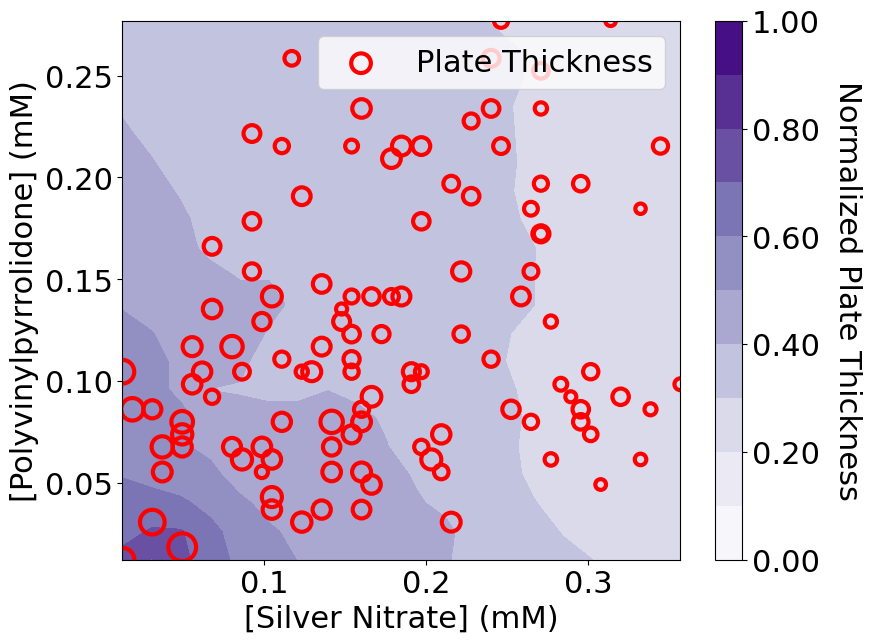

In [37]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(9, 7))
plot_pt_2D(x1, x2, y_pred, 'Normalized Plate Thickness')
#plot_data_2D_2(x, t)
plot_data_2D(x, t)

plt.ylabel('[Polyvinylpyrrolidone] (mM)')
plt.xlabel('[Silver Nitrate] (mM)')
#plt.xlabel('[Tannic Acid] (mM)')
#plt.ylabel('[Silver Nitrate] (mM)')
#plt.ylabel('[Silver Seeds] (mM)')
plt.legend(loc = 1)
#plt.savefig('../../Figures/230421/PVP_SN_platethickness.jpg', dpi = 400, bbox_inches="tight")
plt.show()

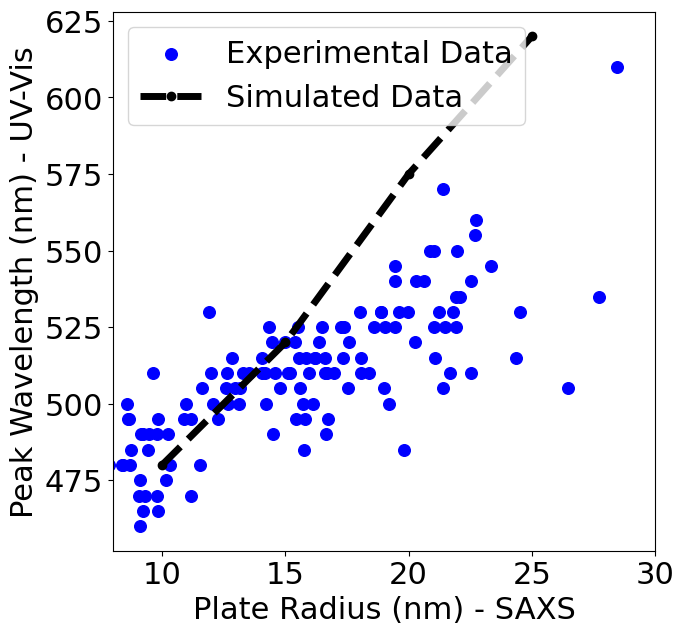

In [65]:
#simulated spectra data
sim_radius = np.array([10, 15, 20, 25])
sim_peak_wv = np.array([480, 520, 575, 620])
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(radius/10, peak_wv, s = 70, color = 'blue', label = 'Experimental Data')
#ax.scatter(peak_wv_bio, r/10, s = 70, color = 'red', label = 'Experimental Data')
ax.plot(sim_radius, sim_peak_wv, "--o", color = 'black', linewidth = 5, label = 'Simulated Data')
ax.set_xlabel('Plate Radius (nm) - SAXS')
ax.set_ylabel('Peak Wavelength (nm) - UV-Vis')
ax.set_xlim([8,30])
# ax2 = ax.twinx()
# ax2.scatter(peak_wv,t/10, s = 70, color = 'red', label = 'Thickness')
# ax2.scatter(-5,-5, color = 'blue', s = 70, label = 'Radius')
# ax2.set_ylabel('Plate Thickness (nm) - SAXS', color='red')
# ax.set_ylim([5,35])
# ax2.set_ylim([5,20])
# ax2.set_yticks([0,5,10,15,20])
# ax.set_xlim([450, 600])
# ax2.set_xticks([470, 500, 530, 560])
ax.legend(loc=2)
#plt.savefig('../../Figures/230421/UV_SAXS_radius_simulated_2.png', bbox_inches="tight", dpi = 500)